In [5]:
import numpy as np
import ymmsl
import yaml
import sobol_seq
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# Read_ymmsl_file
def read_ymmsl_file(path,filename):
    final_path = path + filename
    with open(final_path) as f:
        ymmsl_data = ymmsl.load(f)
        
    return ymmsl_data

In [20]:
# save ymmsl file
def write_ymmsl_file(path,filename,config_data):
    with open(path+filename, 'w') as f:
        ymmsl.save(config_data, f)

In [21]:
# Transform the normalized sample matrix to ranges of uncertain parameters
def dim_transform(sobel_vector,uncertain_list):
    
    dim = len(uncertain_list)
    for num_dim in range(dim):
        para_max = uncertain_list[num_dim].get('max')
        para_min = uncertain_list[num_dim].get('min')
        sobel_vector[:,num_dim] = para_min + (para_max-para_min)*sobel_vector[:,num_dim]
        
    return sobel_vector

In [22]:
####################################################################################
##### Sample generation and UQ campaign creation (including instances folder)#######
####################################################################################
# Note:
#  This is used to generate UQ samples for only four biological parameters:
#	1) Endothelium endpoint 2)smc max stran 3)balloon extension 4) Fenestration probability

# Naming of Folder and files for samples
# Level 0:    UQtest                                    (UQ campaign name)
# Level 1:    UQtest/A                                  (sample matrix of sobol sequence)
# Level 2:    UQtest/A/A_X where X vary from 1 -> N     (N: number of samples)
# Level 3:    UQtest/A/A_X/input.ymmsl


In [23]:
### Main function
# Number of samples for UQ
N_sample = 128

# Template path to the ymmsl file (relative path from ISR3D/Result/UQtest/ to ISR3D/UQ/template/input_stage4.ymmsl)
input_path = '../../UQ/template/'
input_ymmsl_filename = 'input_stage4.ymmsl'

# Output directory for UQ campagin folder and name
output_path = './'
experiment_name = 'UQtest'

In [24]:
# Read in the data of template ymmsl file
ymmsl_data = read_ymmsl_file(input_path,input_ymmsl_filename)

In [25]:
# Take out the unchanged model part and need-for-change settings part for ymmsl model
model = ymmsl_data.model
settings = ymmsl_data.settings

In [26]:
# Set uncertain parameters and its ranges as a list
ymmsl_uncertain_parameters = [
        {
            'name': 'smc.endo_endpoint',
            'min': 10.0,
            'max': 20.0
        },
        {
            'name': 'smc.balloon_extension',
            'min': 0.5,
            'max': 1.5
        },
        {
            'name': 'smc.smc_max_strain',
            'min': 1.2,
            'max': 1.8
        },
        {
            'name': 'smc.fenestration_probability',
            'min': 0.0,# Calculate the lumen volume from (lumen_area_of_each_slice*depth_of_slice)
            'max': 0.1
        }]

In [27]:
# Count the total uncertain input dimensions (here 4 parameters)
num_uncer_para = len(ymmsl_uncertain_parameters)
print('Number of uncertain parameter: '+str(num_uncer_para))

Number of uncertain parameter: 4


In [28]:
# Generate sobel sequence range (0,1), save the file and transform to (min,max)
A = sobol_seq.i4_sobol_generate(num_uncer_para,N_sample)
A = dim_transform(A,ymmsl_uncertain_parameters)
np.savetxt("A.csv",A)

In [29]:
# Create corresponding directory and folders
try:
    os.mkdir(output_path+experiment_name)
except OSError:
    print ("Creation of the directory %s failed" % output_path+experiment_name)
else:
    print ("Successfully created the directory %s" % output_path+experiment_name)

Successfully created the directory ./UQtest


In [30]:
# A: Replace the corresponding value within the dict and output the file
os.mkdir(output_path+experiment_name+'/A')
checklist = ['A']

for n in range(N_sample):
    sample_path = output_path+experiment_name+'/A'+'/A_'+str(n)
    os.mkdir(sample_path)
    
    # Generate file for ymmsl 
    num_para = 0
    for para in ymmsl_uncertain_parameters:
        settings[para.get('name')] = float(A[n,num_para])
        num_para = num_para + 1
        
    config = ymmsl.Configuration(model, settings)
    write_ymmsl_file(sample_path+'/','input_stage4.ymmsl',config)

print('Wrting and saving procedure done: A')

Wrting and saving procedure done: A


In [31]:
####################################################################################
##### Run shell script to broadcast other input files to each sample folder#########
####################################################################################

In [32]:
import subprocess
# Template path to the ymmsl file (relative path from ISR3D/Result/UQtest/ to ISR3D/UQ/function/BCastStage3.sh)
subprocess.call(['bash','../../UQ/function/BCastStage3.sh']) 

0

In [34]:
####################################################################################################
##### You can copy the slurm job array to the directory and launch through terminal ################
##### Or directly do it here                                                        ################
####################################################################################################

In [35]:
subprocess.run(["sbatch", "../../UQ/slurm/job_array.sl"])

CompletedProcess(args=['sbatch', '../../UQ/slurm/job_array.sl'], returncode=0)

In [2]:
################################################################################
###### Fetch the result data and plot out the PDF and mean+/-STD figures #######
################################################################################

In [7]:
# Function of reading data
def LumenRead(path,numfile):
    
    resultlist = np.empty((0,39), float)
    for i in range(numfile):
        filename = os.path.join(path,('lumen_area_000'+str("{0:0=3d}".format(i))+'.csv'))
        reader = csv.reader(open(filename, "r"), delimiter='\t')
        x = list(reader)
        result = np.array(x[0][:-1]).astype("float")
        resultlist = np.append(resultlist, np.expand_dims(result,axis=0), axis=0)
        
    # print(resultlist.shape)
    return resultlist

In [8]:
# Set Directory and number of instance in the UQ campaign
data_root = './UQtest/A/'
time_step = 361

# Read the all subdirectory of UQ instances in a list
data_list = [os.path.join(data_root, item) for item in sorted(os.listdir(data_root))]

#Create an empty list and fetch the data in an loop
lumen_list = np.empty((0,time_step,39), float)
for item in data_list:
    print('Processing:',item) 
    Data = LumenRead(item,time_step)
    lumen_list = np.append(lumen_list,np.expand_dims(Data,axis=0),axis=0)

print(lumen_list.shape)	
np.save('LumenData',lumen_list)

Processing: ./UQtest/A/A_0
Processing: ./UQtest/A/A_1
Processing: ./UQtest/A/A_10
Processing: ./UQtest/A/A_100
Processing: ./UQtest/A/A_101
Processing: ./UQtest/A/A_102
Processing: ./UQtest/A/A_103
Processing: ./UQtest/A/A_104
Processing: ./UQtest/A/A_105
Processing: ./UQtest/A/A_106
Processing: ./UQtest/A/A_107
Processing: ./UQtest/A/A_108
Processing: ./UQtest/A/A_109
Processing: ./UQtest/A/A_11
Processing: ./UQtest/A/A_110
Processing: ./UQtest/A/A_111
Processing: ./UQtest/A/A_112
Processing: ./UQtest/A/A_113
Processing: ./UQtest/A/A_114
Processing: ./UQtest/A/A_115
Processing: ./UQtest/A/A_116
Processing: ./UQtest/A/A_117
Processing: ./UQtest/A/A_118
Processing: ./UQtest/A/A_119
Processing: ./UQtest/A/A_12
Processing: ./UQtest/A/A_120
Processing: ./UQtest/A/A_121
Processing: ./UQtest/A/A_122
Processing: ./UQtest/A/A_123
Processing: ./UQtest/A/A_124
Processing: ./UQtest/A/A_125
Processing: ./UQtest/A/A_126
Processing: ./UQtest/A/A_127
Processing: ./UQtest/A/A_13
Processing: ./UQtest/A

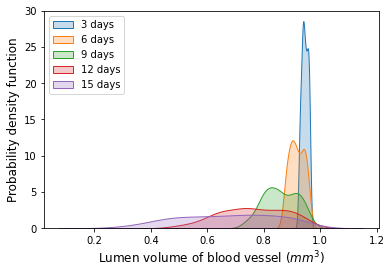

In [15]:
# Calculate the lumen volume from (lumen_area_of_each_slice*depth_of_slice)
lumen_list = np.load('LumenData.npy')
lumen_vol = np.sum(lumen_list[:,:,:],axis=2) * 0.03125
fig = plt.figure()

# plt.plot(np.ones(128)*3.56055,np.linspace(0.0,2.5,128),label='0 days',c='k')
sns.kdeplot(lumen_vol[:,72],label='3 days',fill=True)
sns.kdeplot(lumen_vol[:,144],label='6 days',fill=True)
sns.kdeplot(lumen_vol[:,216],label='9 days',fill=True)
sns.kdeplot(lumen_vol[:,288],label='12 days',fill=True)
sns.kdeplot(lumen_vol[:,360],label='15 days',fill=True)
plt.legend(fontsize=10,loc=2)
plt.xlabel('Lumen volume of blood vessel ($mm^3$)',fontsize=12)
plt.ylabel('Probability density function',fontsize=12)
plt.savefig('./'+'pdf.png')
plt.show()

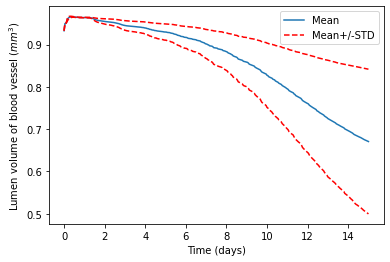

In [14]:
# plot mean+/-STD
days = np.zeros(361)
for i in range(361):
    days[i] = i/24

plt.plot(days, np.mean(lumen_vol,axis=0),label='Mean')
plt.plot(days, np.mean(lumen_vol,axis=0) - np.std(lumen_vol,axis=0), '--',color='r',label='Mean+/-STD')
plt.plot(days, np.mean(lumen_vol,axis=0) + np.std(lumen_vol,axis=0), '--',color='r')
plt.xlabel('Time (days)')
plt.ylabel('Lumen volume of blood vessel ($mm^3$)')
plt.legend()
plt.savefig('./'+'mean.png')
plt.show()
